In this project, data scientist job openings will be web scraped and compared in terms of salaries.

# Motivation
1. Can a data scientist's salary be predicted and if so how accurately?
2. What features are important in predicting a data scientist's salary?
3. Another motivation was to see the relative number of data scientist jobs posted in different states in USA.
4. What industries/sectors pay higher salaries?

# Project overview
- The objective is to predict the salary of data scientist positions based on location, seniority, type of the company, industry, etc.
- The dataset used in this project is a combination of dataset obtained from https://www.kaggle.com/andrewmvd/data-scientist-jobs and extra data scientist positions scraped by glassdoor scraper developed and uploaded to this repository
- Cleaned dataset of over 5500 data scientist positions
- Created and optimized Random Forest Regression model by using GridSearchCV to reach MAE=22.32, RMSE=28.61, and R2score=0.40
- Model was saved using joblib library

# Import Libraries
First, the necessary libraries are imported.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
plt.style.use('seaborn')

# for interactive view of plots
# %matplotlib notebook 

# for static view of plots
%matplotlib inline 

import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Data Cleaning
In this section, the data is cleaned and prepared for next steps.

- Parsed the salary estimates out of the raw data
- Created "Hourly" and "Employer_provided" columns to distinguish if a salary estimate was based on hourly rates and provided by the employer, respectively
- Created minimum and maximum salary columns for the positions and parsed the corresponding values out of the raw dat
- Created average salary column
- Cleaned the company name column by removing the ratings
- Extracted the state where each position is located. Created a state column
- Created founded column which contains the year each company was founded
- Using the founded column, the company age column was created
- Seniority column was created to show if a position was a senior role
- Title column was created to show the different categories for the posted roles such as data engineer, deep learning, analyst, ...
- For all the column if the corresponding value was not available, -1 was assigned for the particular position

In [2]:
def get_clean_dataframe(num_jobs=100):
    """
    Gets raw dataframe directly from glassdoor_scraper.py or from a csv file.
    Cleans the raw dataframe.
    
    args:
        int num_jobs: number of desirable jobs passed to the scraper
    
    return:
        Dataframe df: cleaned dataframe
    """
    
    # df = gs.get_jobs(num_jobs=num_jobs)
    
    df = pd.read_csv('./data/df.csv')
    
    #%% Salary
    
    # Remove instances without salary estimates
    df = df[df['Salary Estimate'] != '-1']
    
    ## Remove K and $ 
    df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.replace('K', '').replace('$', ''))
    
    ## Add hourly and employer provided binary columns
    df['Hourly'] = df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
    df['Employer_provided'] = df['Salary Estimate'].apply(lambda x: 1 if 'employer est' in x.lower() else 0)
    
    ## Add min, max, and average salary columns and cast them into integer type
    df['Min_salary'] = df['Salary Estimate'].apply(lambda x: int(x.split('-')[0]))
    # df['Max_salary'] = df['Salary Estimate'].apply(lambda x: int(x.split('$')[1]))
    df['Max_salary'] = df['Salary Estimate'].apply(lambda x: x.split('-')[1]).replace('[^0-9]', '', regex=True)
    df['Max_salary'] = df['Max_salary'].apply(int)
    
    ### Convert hourly wages to annual
    df['Min_salary'] = df.apply(lambda x: x.Min_salary if x.Hourly == 0 else x.Min_salary*2.05, axis=1)
    df['Max_salary'] = df.apply(lambda x: x.Max_salary if x.Hourly == 0 else x.Max_salary*2.05, axis=1)
    
    df['Average_salary'] = (df.Min_salary + df.Max_salary)/2
    
    ## Remove the initial salary estimate column
    df.drop('Salary Estimate', axis=1, inplace=True)
    
    #%% Rating
    
    ## Ensure ratings are float type
    df['Rating'] = df['Rating'].apply(lambda x: float(x))
    
    #%% Company name
    
    ## Remove rating from the end of company names
    df['Company Name'] = df['Company Name'].apply(lambda x: x.split('\n')[0])
    
    #%% State: what state is the job in
    
    df['State'] = df['Location'].apply(lambda x: x.split()[-1])
    df = df[df.State != 'Kingdom'] # remove United Kingdom
    df = df[df.State != 'States'] # remove United States
    #%% Company age
    
    # Replace non-numeric cells in Founded column with -1
    df['Founded'].replace('[^0-9]', -1, regex=True, inplace=True)
    
    df['Company_age'] = df['Founded'].apply(lambda x: 2021-int(x) if int(x)>0 else -1)
    
    
    #%% Organize job titles
    
    def title_organizer(x):
        x = x.lower()
        if ('data scientist' in x) or ('data science' in x) :
            return 'data scientist'
        elif 'data engineer' in x:
            return 'data engineer'
        elif 'deep learning' in x:
            return 'deep learning engineer'
        elif 'machine learning' in x:
            return 'machine learning engineer'
        elif 'director' in x:
            return 'director'
        elif 'manager' in x:
            return 'manager'
        elif 'analyst' in x:
            return 'analyst'
        elif 'researcher' in x:
            return 'researcher'
        else:
            return 'other'
    df['Title'] = df['Job Title'].apply(title_organizer)
    
    #%% Senior position?
    
    def senior_junior(x):
        x = x.lower()
        if 'sr' in x or 'senior' in x or 'sr.' in x or 'lead' in x or 'principal' in x or 'vp' in x or 'manager' in x:
            return 'senior'
        elif 'jr' in x or 'junior' in x or 'jr.' in x:
            return 'junior'
        else:
            return 'other'
    df['Seniority'] = df['Job Title'].apply(senior_junior)        
    
    #%% Size
    
    df['Size'].replace('Unknown', '-1', regex=True, inplace=True)
    
    #%% Type of ownership
    
    df['Type of ownership'].replace('Unknown', '-1', regex=True, inplace=True)
    
    #%% Drop unwanted columns, reorder the remining columns, and write the dataframe to csv format
    
    # Max_salary and Min_salary are dropped too because we calculated the
    # response variable, Average_salary, by using them.
    df.drop(['Company Name', 'Location', 'Founded', 'Job Title', 
             'Revenue', 'Min_salary', 'Max_salary'], inplace=True,
            axis=1)
    
    df = df.reindex(columns=['Average_salary', 'Title','Seniority', 
                             'Rating', 'Hourly', 'Employer_provided', 
                             'Company_age', 
                             'Industry', 'Sector', 'Type of ownership',
                             'Size', 'State'])
    
    df.to_csv('./data/df_cleaned.csv', index=False)
    
    return df

# run the function
# get_clean_dataframe()

# Exploratory Data Analysis (EDA)
Here, we will take a peek at the data and visualize them.

## Define functions for creating plots
Next, different plots are created for different features to get a better understanding of data.

In [3]:
def get_hist(df):
    
    """plot histograms for the numerical features
    arg:
        Dataframe df: dataframe of jobs
    """
    df.hist(bins=15)
    plt.show()

In [4]:
def get_boxplot(df, columns_list):
    
    """plot boxplots for the listed numerical features
    args:
        Dataframe df: dataframe of jobs
        list column_list: list of columns you want to be plotted
    """
    df.boxplot(column=columns_list)
    plt.show()

In [5]:
def get_correlation(df):
        
    """plot correlation heatmap for the numerical features
    arg:
        Dataframe df: dataframe of jobs
    """
    ax = plt.axes()
    sns.heatmap(df.corr(), annot=True, fmt='0.2f', ax=ax)
    ax.set_title('Correlation Heatmap')
    plt.show()
    

In [6]:
def get_countplot(df):
    
    """plot bar charts (count plots) for the categorical features
    arg:
        Dataframe df: dataframe of jobs
    """
    for col in df.select_dtypes(include=['object']).columns:
        try: # for columns with more than 20 unique values, only plot top 20
            ax = sns.countplot(x=col, data=df, palette='Spectral',
                               order=df[col].value_counts().iloc[:20].index)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            plt.show()
        except:
            ax = sns.countplot(x=col, data=df, palette='Spectral',
                               order=df[col].value_counts().index)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            plt.show()

## Read in the data set

In [7]:
df = pd.read_csv('./data/df_cleaned.csv')

## Use plot functions defined above to create plots

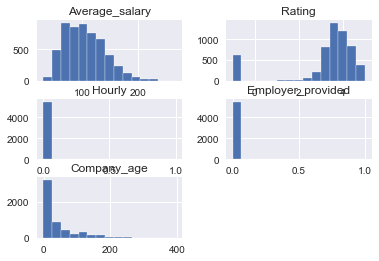

In [8]:
get_hist(df)

In the above plot, the distributions of numerical features and the response variable (Average_salary) are displayed. It can be seen that the average salary distribution is nearly a normal distribution but skewed to the left. Also, the salary numbers are divided by 1000 and are in USD.

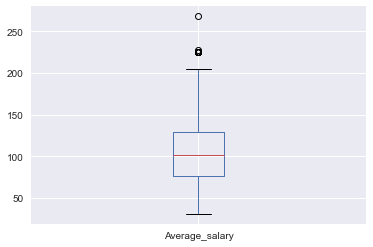

In [9]:
get_boxplot(df, ['Average_salary'])

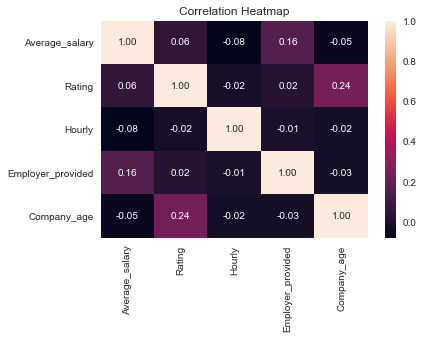

In [10]:
get_correlation(df)

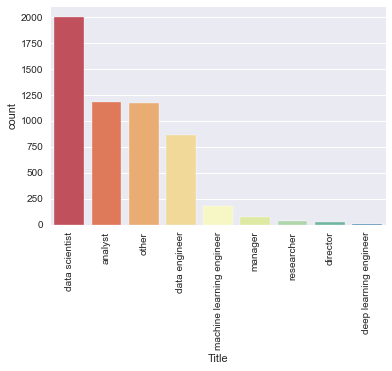

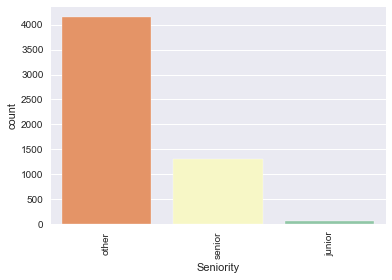

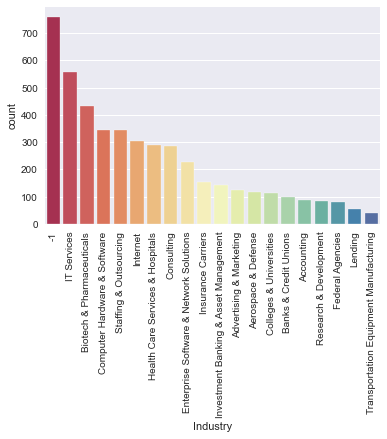

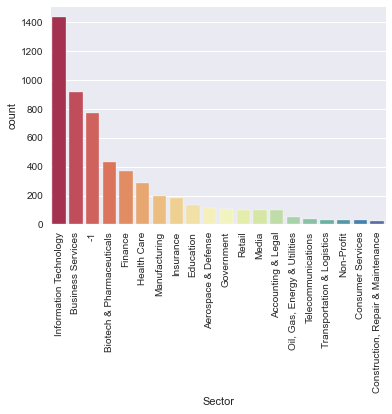

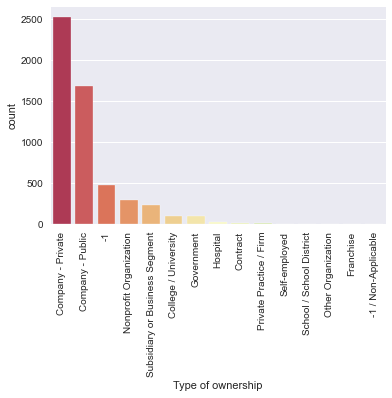

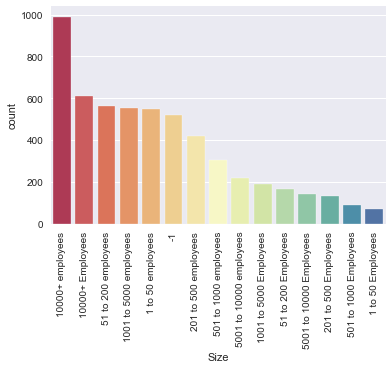

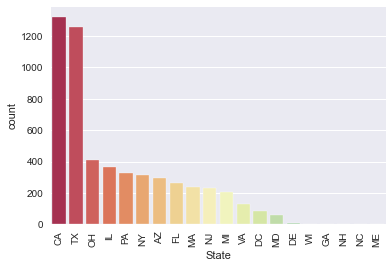

In [11]:
get_countplot(df)

In [12]:
# extracting the response variable
y = df.pop("Average_salary")

In [13]:
def get_features(X):
    """
    Fills in the null values for numerical values.
    Creates dummies for categorical variables.
    Produces the final feature matrix, X.
    
    arg:
        Dataframe X: dataframe of raw features
    returns:
        Dataframe X: dataframe of preprocessed features
    """
    
    # separating numerical and categorical features into two dataframes
    num_X = X.select_dtypes(include=['int', 'float', 'int64', 'float64'])
    cat_X = X.select_dtypes(include=['object'])

    # filling null values of numerical features with their means
    for col in num_X.columns:
        X[col] = X[col].fillna(X[col].mean())

    # creating dummies for categorical variables and producing final X matrix
    for col in cat_X.columns:
        X = pd.concat([X.drop(col, axis=1),
                       pd.get_dummies(X[col], prefix=col, prefix_sep='_',
                                      drop_first=True)], axis=1)
    return X

# saving features matrix as X
X = get_features(df)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
                                                            
rf = RandomForestRegressor(criterion='mse')

cv = cross_val_score(rf,X_train,y_train, 
                     scoring='neg_root_mean_squared_error', cv=10)
print("cross validation scores:\n", cv)
print("the average of the cross validation scores: ", cv.mean())


param_grid =  {'n_estimators': [10, 25, 50, 100, 200, 400, 800, 1000],
                                  'bootstrap': [True],
                                  'max_depth': [2, 5, 10, 15, 20],
                                  'max_features': ['auto','sqrt',10],
                                  'min_samples_leaf': [2,3,4,5,6],
                                  'min_samples_split': [2,3,4]}

cross validation scores:
 [-29.49527541 -30.63479821 -28.84353225 -29.02891128 -31.57868094
 -27.81877741 -29.71955602 -28.19668574 -30.57531573 -31.90246166]
the average of the cross validation scores:  -29.77939946470541


In [ ]:
cv = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = False,
                      n_jobs = -1)
rfs = cv.fit(X_train,y_train)

# picking the best of them
rf = rfs.best_estimator_.fit(X_train,y_train)

# save model using joblib
FILENAME = "rfr_saved_model.sav" # save random forest regressor 
joblib.dump(rf, FILENAME)

C:\Users\Clint\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Clint\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


The optimized Random Forest Regressor model: 
 RandomForestRegressor(max_depth=15, min_samples_leaf=6, min_samples_split=4,
                      n_estimators=1000)
The number of features used to fit the Random Forest Regressor model: 207
Industry_Radio                    0.000000
Industry_Stock Exchanges          0.000000
Industry_Sports & Recreation      0.000000
Industry_Sporting Goods Stores    0.000000
Industry_Shipping                 0.000000
                                    ...   
Employer_provided                 0.073872
Rating                            0.083806
Company_age                       0.087551
State_NY                          0.130976
State_CA                          0.251574
Length: 207, dtype: float64
Random forest regressor's mean absolute error (MAE) =  22.31894159935565
Random forest regressor's roor mean squared error (RMSE) =  28.608449336549587
Random forest regressor's R2 score =  0.3975618663524808


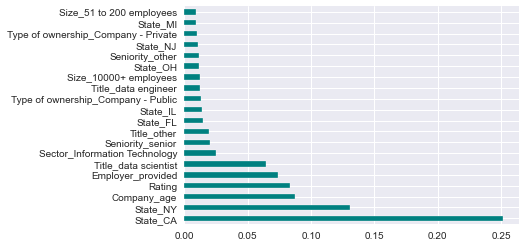

In [15]:
#%% Modeling
try:
    # load the model form disk
    rfr_loaded_model = joblib.load("rfr_saved_model.sav")
    
except:
    print('Model cannot be loaded!')
    
print("The optimized Random Forest Regressor model: \n", rfr_loaded_model)
print("The number of features used to fit the Random Forest Regressor model: {}". format(rfr_loaded_model.n_features_))    

#%% Model's accuracy
X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')
y_pred = rfr_loaded_model.predict(X_test)    

# Which features are more important
feat_importances = pd.Series(rfr_loaded_model.feature_importances_,
                                 index=X_test.columns)
feat_importances.nlargest(20).plot(kind='barh', color='teal')
print(feat_importances.sort_values())
print("Random forest regressor's mean absolute error (MAE) = ", mean_absolute_error(y_test, y_pred))
print("Random forest regressor's roor mean squared error (RMSE) = ", pow(mean_squared_error(y_test, y_pred), 0.5))
print("Random forest regressor's R2 score = ", r2_score(y_test, y_pred))